In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import h5py

archive = h5py.File('/Users/bmmorris/git/aesop/notebooks/spectra.hdf5', 'r+')

In [3]:
targets = list(archive)

In [4]:
list(archive['HD122120'])#['2017-09-11T03:27:13.140']['flux'][:]

['2017-06-15T03:52:13.690']

(8850, 8890)

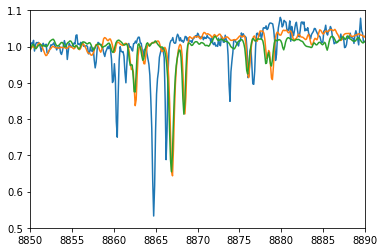

In [5]:
from scipy.ndimage import gaussian_filter1d

spectrum1 = archive['HATP11']['2017-06-12T07:28:06.310'] # K4
spectrum2 = archive['HD110833']['2017-03-17T05:47:24.899']  # K3
spectrum3 = archive['HD122120']['2017-06-15T03:52:13.690'] # K5

wavelength1 = spectrum1['wavelength'][:]
flux1 = spectrum1['flux'][:]

wavelength2 = spectrum2['wavelength'][:]
flux2 = spectrum2['flux'][:]

wavelength3 = spectrum3['wavelength'][:]
flux3 = spectrum3['flux'][:]

plt.plot(wavelength1, flux1)

plt.plot(wavelength2, gaussian_filter1d(flux2, 1))# + 0.2)

plt.plot(wavelength3, gaussian_filter1d(flux3, 1))# + 0.4)

plt.ylim([0.5, 1.1])
#plt.xlim([3900, 4000])
# plt.xlim([7035, 7075])
plt.xlim([8850, 8890])

In [6]:
import sys
sys.path.insert(0, '../')
from toolkit import SimpleSpectrum

In [7]:
import astropy.units as u

target = SimpleSpectrum(wavelength1, flux1, dispersion_unit=u.Angstrom)
source1 = SimpleSpectrum(wavelength2, flux2, dispersion_unit=u.Angstrom)
source2 = SimpleSpectrum(wavelength3, flux3, dispersion_unit=u.Angstrom)

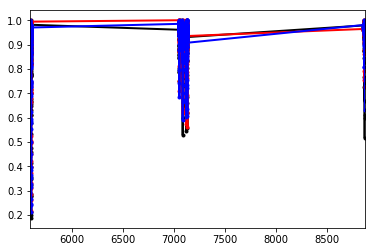

In [10]:
from toolkit import instr_model

from toolkit import slice_spectrum, concatenate_spectra, bands_TiO
spec_band = []

first_n_bands = 5
width = 5

for band in bands_TiO[:first_n_bands]:
    target_slice = slice_spectrum(target, band.min-width*u.Angstrom, band.max+width*u.Angstrom)
    target_slice.flux /= target_slice.flux.max()
    spec_band.append(target_slice)

target_slices = concatenate_spectra(spec_band)
target_slices.plot(color='k', lw=2, marker='.')

spec_band = []
for band, inds in zip(bands_TiO[:first_n_bands], target_slices.wavelength_splits):
    target_slice = slice_spectrum(source1, band.min-width*u.Angstrom, band.max+width*u.Angstrom, 
                                  force_length=abs(np.diff(inds))[0])
    target_slice.flux /= target_slice.flux.max()
    spec_band.append(target_slice)

source1_slices = concatenate_spectra(spec_band)
source1_slices.plot(color='r', lw=2, marker='.')

spec_band = []
for band, inds in zip(bands_TiO[:first_n_bands], target_slices.wavelength_splits):
    target_slice = slice_spectrum(source2, band.min-width*u.Angstrom, band.max+width*u.Angstrom, 
                                  force_length=abs(np.diff(inds))[0])
    target_slice.flux /= target_slice.flux.max()
    spec_band.append(target_slice)

source2_slices = concatenate_spectra(spec_band)
source2_slices.plot(color='b', lw=2, marker='.')

(<matplotlib.figure.Figure at 0x11f93fac8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11fb4f908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e810b00>], dtype=object))

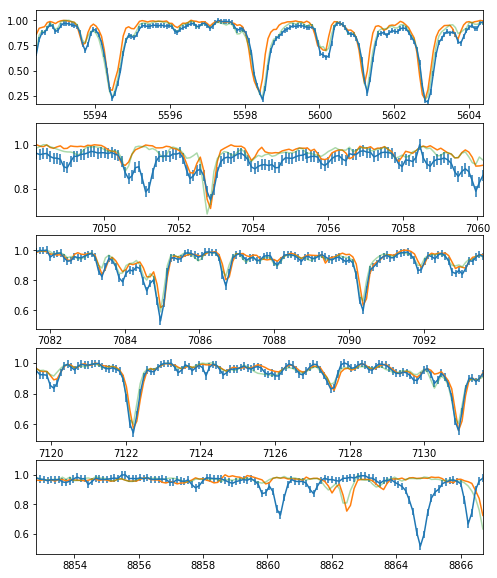

In [11]:
def plot_spliced_spectrum(observed_spectrum, model_flux, other_model=None):
    n_chunks = len(observed_spectrum.wavelength_splits)
    fig, ax = plt.subplots(n_chunks, 1, figsize=(8, 10))

    for i, inds in enumerate(observed_spectrum.wavelength_splits):
        min_ind, max_ind = inds
        
        ax[i].errorbar(observed_spectrum.wavelength[min_ind:max_ind].value, 
                       observed_spectrum.flux[min_ind:max_ind], 
                       0.025*np.ones(max_ind-min_ind))
        ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                   model_flux[min_ind:max_ind])
        
        if other_model is not None:
            ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                       other_model[min_ind:max_ind], alpha=0.4)
        
        ax[i].set_xlim([observed_spectrum.wavelength[min_ind].value,
                        observed_spectrum.wavelength[max_ind-1].value])
        ax[i].set_ylim([0.9*observed_spectrum.flux[min_ind:max_ind].min(), 
                        1.1])

    return fig, ax

plot_spliced_spectrum(target_slices, source1_slices.flux, source2_slices.flux)

In [12]:
model, resid = instr_model(target_slices, source1_slices, source2_slices, np.log(0.5), 1, 1, 0, 0, 0, 0, 0)

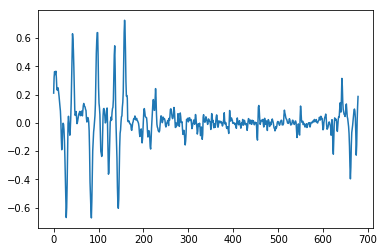

In [13]:
plt.plot(target_slices.flux - model)

In [51]:
# from scipy.optimize import fmin_l_bfgs_b

# def chi2(p, target, temp_phot, temp_spot):
#     spotted_area, lam_offset0, lam_offset1, lam_offset2, res = p
#     lam_offsets = [lam_offset0, lam_offset1, lam_offset1]
#     model, residuals = instr_model(target, temp_phot, temp_spot, spotted_area, 
#                                    res, *lam_offsets)
#     return residuals

# bounds = [[-30, 0], [-2, 2], [-2, 2], [-2, 2], [1, 15]]
# initp = [np.log(0.03), 0.0, 0.0, 0.0, 1]

# bfgs_options_fast = dict(epsilon=1e-3, approx_grad=True,
#                          m=10, maxls=20)
# bfgs_options_precise = dict(epsilon=1e-3, approx_grad=True,
#                             m=30, maxls=50)

# result = fmin_l_bfgs_b(chi2, initp, bounds=bounds, 
#                        args=(target_slices, source1_slices, source2_slices),
#                        **bfgs_options_precise)
#                        #**bfgs_options_fast)

In [52]:
# model, resid = instr_model(target_slices, source1_slices, source2_slices, *result[0])

In [53]:
# plot_spliced_spectrum(target_slices, model)

In [54]:
import emcee

yerr = 0.01

def random_in_range(min, max):
    return (max-min)*np.random.rand(1)[0] + min

def lnprior(theta):
    log_spotted_area, res = theta[:2]
    dlambdas = theta[2:]
    if (-15 < log_spotted_area <= 0 and 0. <= res < 3 and all([-3 < dlambda < 3 for dlambda in dlambdas])):
        return 0.0
    return -np.inf

def lnlike(theta, target, source1, source2):
    log_spotted_area, res = theta[:2]
    dlambdas = theta[2:]
    model, residuals = instr_model(target, source1, source2, np.exp(log_spotted_area), 
                                   res, *dlambdas)
    return -0.5*residuals/yerr**2

def lnprob(theta, target, source1, source2):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, target, source1, source2)

from emcee import EnsembleSampler

dlam_init = -0.2
# initp = np.array([np.log(0.01), 1, dlam_init, dlam_init, dlam_init, dlam_init, dlam_init])
ndim, nwalkers = 6, 30

pos = []

counter = -1
while len(pos) < nwalkers:
    realization = [random_in_range(-10, -8), random_in_range(0, 1),
                   random_in_range(dlam_init-0.1, dlam_init+0.1), random_in_range(dlam_init-0.1, dlam_init+0.1), 
                   random_in_range(dlam_init-0.1, dlam_init+0.1), random_in_range(dlam_init-0.1, dlam_init+0.1)]
    if np.isfinite(lnprior(realization)):
        pos.append(realization)

sampler = EnsembleSampler(nwalkers, ndim, lnprob, threads=8, 
                          args=(target_slices, source1_slices, source2_slices))

In [55]:
sampler.run_mcmc(pos, 4000);

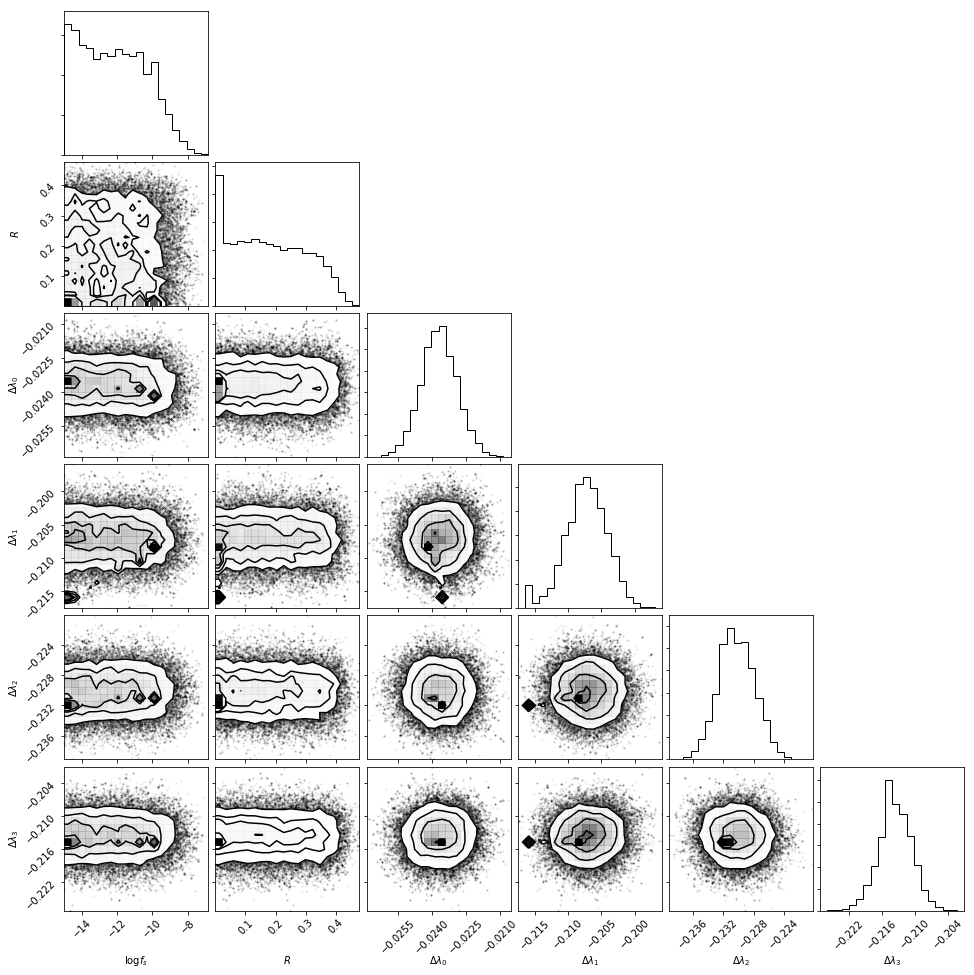

In [56]:
from corner import corner

samples = sampler.chain[:, 1500:, :].reshape((-1, ndim))

corner(samples, labels=['$\log f_s$', '$R$', '$\Delta \lambda_0$', '$\Delta \lambda_1$', 
                        '$\Delta \lambda_2$', '$\Delta \lambda_3$']);#, '$\Delta \lambda_4$']);

In [57]:
best_params = sampler.flatchain[np.argmax(sampler.flatlnprobability, axis=0), :]
best_model = instr_model(target_slices, source1_slices, source2_slices, 
                         *best_params)[0]

In [58]:
best_params

array([-9.85471612,  0.01298906, -0.02402099, -0.20847117, -0.23079841,
       -0.21439622])

In [59]:
# maximum spotted area 
np.exp(np.percentile(samples[:, 0], 98))

0.00017701053774949848

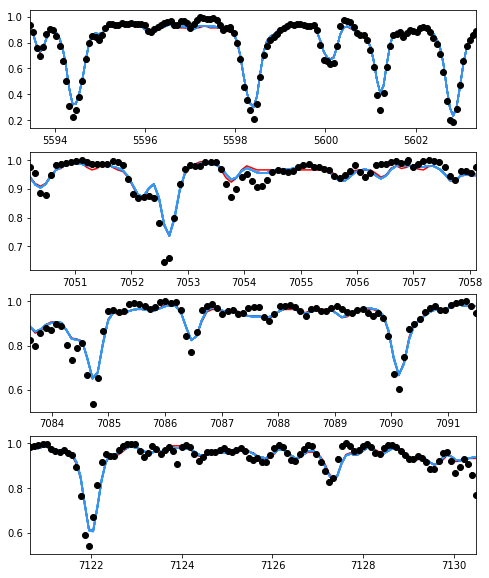

In [60]:
n_chunks = len(target_slices.wavelength_splits)
fig, ax = plt.subplots(n_chunks, 1, figsize=(8, 10))

from copy import deepcopy
from toolkit.analysis import gaussian_kernel

for i, inds in enumerate(target_slices.wavelength_splits):
    min_ind, max_ind = inds

    ax[i].errorbar(target_slices.wavelength[min_ind:max_ind].value, 
                   target_slices.flux[min_ind:max_ind], 
                   yerr*np.ones_like(target_slices.flux[min_ind:max_ind]), 
                   fmt='o', color='k')
                   #0.025*np.ones(max_ind-min_ind), fmt='.')
    ax[i].plot(target_slices.wavelength[min_ind:max_ind], 
               best_model[min_ind:max_ind], color='r')

    ax[i].set_xlim([target_slices.wavelength[min_ind].value, 
                   target_slices.wavelength[max_ind-1].value])
    #ax[i].set_ylim([0.9*target_slices.flux[min_ind:max_ind].min(), 
    #                1.1])

n_random_draws = 100
# draw models from posteriors
for j in range(n_random_draws):
    step = np.random.randint(0, samples.shape[0])
    random_step = samples[step, :]

    rand_model = instr_model(target_slices, source1_slices, source2_slices, *random_step)[0]

    for i, inds in enumerate(target_slices.wavelength_splits):
        min_ind, max_ind = inds
        ax[i].plot(target_slices.wavelength[min_ind:max_ind], 
                   rand_model[min_ind:max_ind], color='#389df7', alpha=0.1)